In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
CLASS_NUM = 10
IMAGE_SIZE_W = 28
IMAGE_SIZE_H = 28
FLATTEN_SIZE = IMAGE_SIZE_W*IMAGE_SIZE_H

### データの読み込み

In [4]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
print(train_data.shape)
print(test_data.shape)

(42000, 785)
(28000, 784)


In [5]:
y = "label"
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(y, axis=1), 
                                                        train_data[y],
                                                        stratify=train_data[y],
                                                        random_state=0,
                                                        train_size=0.6)
print("X_train:{}\ny_train:{}".format(X_train.shape, y_train.shape))
print("X_test :{}\ny_test :{}".format(X_test.shape, y_test.shape))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


X_train:(25200, 784)
y_train:(25200,)
X_test :(16800, 784)
y_test :(16800,)


In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(25200, 784) (25200,)
(16800, 784) (16800,)


### [0, 1]に正規化する

In [7]:
X_train /= 255
X_test /= 255
test_data /= 255

### 描画関数の定義

In [8]:
def plot_image(data, i):
    plt.imshow(1-data.iloc[i, :].reshape(IMAGE_SIZE_H, IMAGE_SIZE_W), 'gray')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


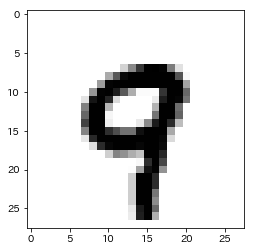

In [9]:
plot_image(X_train, 0)

### 正解ラベルの作成

In [10]:
#one-hotエンコーディング
y_train = np_utils.to_categorical(y_train, CLASS_NUM)
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

0    2479.0
1    2810.0
2    2506.0
3    2611.0
4    2443.0
5    2277.0
6    2482.0
7    2641.0
8    2438.0
9    2513.0
dtype: float32


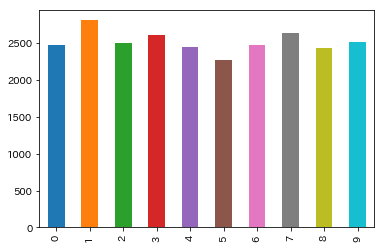

In [11]:
y_train_df = pd.DataFrame(y_train, columns=list(range(CLASS_NUM)))
print(y_train_df.sum())
y_train_df.sum().plot(kind="bar")

教師データに隔たりはなさそう

In [12]:
y_test = np_utils.to_categorical(y_test, CLASS_NUM)

### シンプルなニューラルネットワークを構築

In [13]:
nn_model1 = Sequential()
nn_model1.add(Dense(128, input_shape=(FLATTEN_SIZE,)))
nn_model1.add(Activation("relu"))
nn_model1.add(Dense(128))
nn_model1.add(Activation("relu"))
nn_model1.add(Dense(CLASS_NUM))
nn_model1.add(Activation("softmax"))
nn_model1.summary()
nn_model1.name = "base_network"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [14]:
EPOCH_SIZE = 50
BATCH_SIZE = 200

In [15]:
nn_model1.compile(loss="categorical_crossentropy", optimizer=SGD(), metrics=["accuracy"])

history1 = nn_model1.fit(X_train, y_train, verbose=0,
             epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_split=0.3)

In [16]:
nn_model1.evaluate(X_test, y_test)

16800/16800 [==============================] - 1s 41us/step


[0.25200681159893673, 0.9244642857142857]

In [17]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

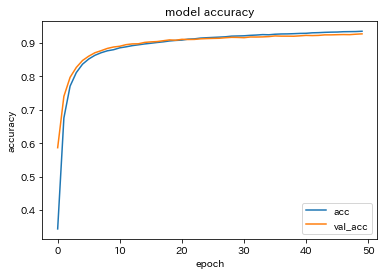

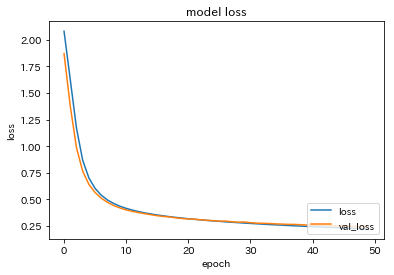

In [18]:
plot_history(history1)

### ドロップアウト層の追加

In [19]:
from keras.layers import Dropout

In [20]:
nn_model2 = Sequential()
nn_model2.add(Dense(128, input_shape=(FLATTEN_SIZE,)))
nn_model2.add(Activation("relu"))
nn_model2.add(Dropout(0.3)) #ドロップアウト層 追加
nn_model2.add(Dense(128))
nn_model2.add(Activation("relu"))
nn_model2.add(Dropout(0.3)) #ドロップアウト層 追加
nn_model2.add(Dense(CLASS_NUM))
nn_model2.add(Activation("softmax"))
nn_model2.summary()
nn_model2.name = "add_dropout"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
__________

In [21]:
nn_model2.compile(loss="categorical_crossentropy", optimizer=SGD(), metrics=["accuracy"])

history2 = nn_model2.fit(X_train, y_train, verbose=0,
             epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_split=0.3)

In [22]:
nn_model2.evaluate(X_test, y_test)

16800/16800 [==============================] - 1s 41us/step


[0.2576335581498487, 0.9218452380952381]

In [23]:
def plot_compare_history(histories, index, names):
    for history in histories:
        plt.plot(history.history[index])
    plt.title('compare history ')
    plt.xlabel('epoch')
    plt.ylabel(index)
    plt.legend(names, loc='lower right')
    plt.show()

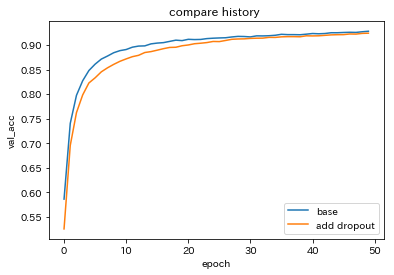

In [24]:
plot_compare_history([history1, history2], "val_acc", ["base", "add dropout"])

### 最適化アルゴリズムの変更

In [25]:
from keras.optimizers import RMSprop
nn_model3 = Sequential()
nn_model3.add(Dense(128, input_shape=(FLATTEN_SIZE,)))
nn_model3.add(Activation("relu"))
nn_model3.add(Dropout(0.3))
nn_model3.add(Dense(128))
nn_model3.add(Activation("relu"))
nn_model3.add(Dropout(0.3))
nn_model3.add(Dense(CLASS_NUM))
nn_model3.add(Activation("softmax"))

nn_model3.compile(loss="categorical_crossentropy", 
                  optimizer=RMSprop(),  #RMSpropに変更
                  metrics=["accuracy"])

history3 = nn_model3.fit(X_train, y_train, verbose=0,
             epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_split=0.3)

nn_model3.evaluate(X_test, y_test)

16800/16800 [==============================] - 1s 39us/step


[0.17944935826018557, 0.9667857142857142]

In [26]:
from keras.optimizers import Adam
nn_model4 = Sequential()
nn_model4.add(Dense(128, input_shape=(FLATTEN_SIZE,)))
nn_model4.add(Activation("relu"))
nn_model4.add(Dropout(0.3))
nn_model4.add(Dense(128))
nn_model4.add(Activation("relu"))
nn_model4.add(Dropout(0.3))
nn_model4.add(Dense(CLASS_NUM))
nn_model4.add(Activation("softmax"))

nn_model4.compile(loss="categorical_crossentropy", 
                  optimizer=Adam(),  #Adamに変更
                  metrics=["accuracy"])

history4 = nn_model4.fit(X_train, y_train, verbose=0,
             epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_split=0.3)

nn_model4.evaluate(X_test, y_test)

16800/16800 [==============================] - 1s 43us/step


[0.14556879879872472, 0.9679761904761904]

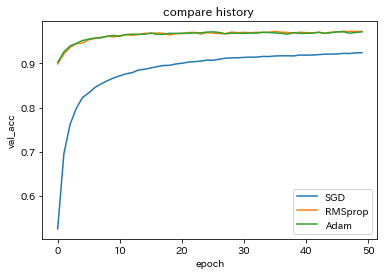

In [27]:
plot_compare_history([history2, history3, history4], "val_acc", ["SGD", "RMSprop", "Adam"])

RMSpropまたはAdamの方が、SGDより精度も高く収束も速い  
エポック数は、20くらいで十分そう

In [28]:
EPOCH_SIZE = 20

### 学習率の調整
* Adamを使い学習率による精度の変化を確認する

In [29]:
nn_model = Sequential()
nn_model.add(Dense(128, input_shape=(FLATTEN_SIZE,)))
nn_model.add(Activation("relu"))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(128))
nn_model.add(Activation("relu"))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(CLASS_NUM))
nn_model.add(Activation("softmax"))

histories = []
names = []
test_scores = []
lr_list = [0.0001, 0.001, 0.01]
for lr in lr_list:
    names.append("Adam_lr_"+str(lr))
    nn_model.compile(loss="categorical_crossentropy", 
                      optimizer=Adam(lr=lr), 
                      metrics=["accuracy"])

    history = nn_model.fit(X_train, y_train, verbose=0,
                 epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_split=0.3)
    histories.append(history)

    score = nn_model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(score)

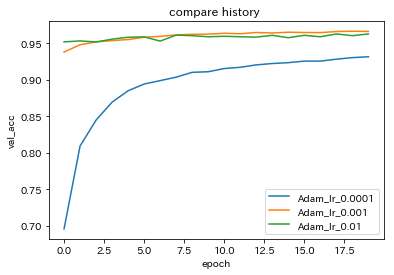

In [30]:
plot_compare_history(histories, "val_acc", names)

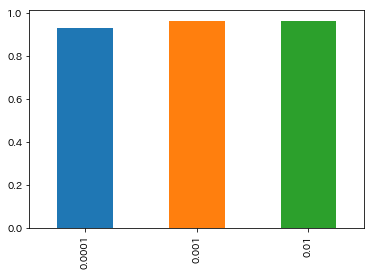

In [31]:
test_scores_df = pd.DataFrame(test_scores, index=lr_list)
test_scores_df[1].plot(kind="bar")

### 隠れ層の調整

In [32]:
histories = []
names = []
test_scores = []
hidden_num_list = [8, 16, 32, 64, 128, 256, 512]
for hidden_num in hidden_num_list:
    nn_model = Sequential()
    nn_model.add(Dense(hidden_num, input_shape=(FLATTEN_SIZE,)))
    nn_model.add(Activation("relu"))
    nn_model.add(Dropout(0.3))
    nn_model.add(Dense(hidden_num))
    nn_model.add(Activation("relu"))
    nn_model.add(Dropout(0.3))
    nn_model.add(Dense(CLASS_NUM))
    nn_model.add(Activation("softmax"))

    names.append("hidden_num_"+str(hidden_num))
    nn_model.compile(loss="categorical_crossentropy", 
                      optimizer=Adam(), 
                      metrics=["accuracy"])

    history = nn_model.fit(X_train, y_train, verbose=0,
                 epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_split=0.3)
    histories.append(history)

    score = nn_model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(score)

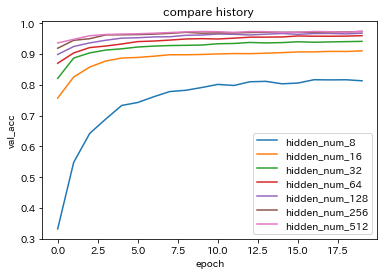

In [33]:
plot_compare_history(histories, "val_acc", names)

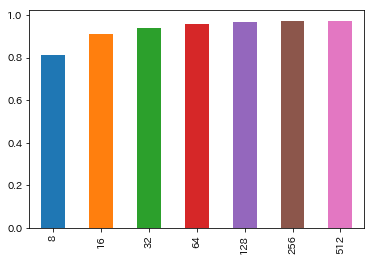

In [34]:
test_scores_df = pd.DataFrame(test_scores, index=hidden_num_list)
test_scores_df[1].plot(kind="bar")

In [35]:
test_scores_df

,0,1
8,0.828927,0.811012
16,0.322217,0.910179
32,0.208720,0.939524
64,0.148847,0.957024
128,0.123481,0.965417
256,0.112557,0.971131
512,0.116586,0.973155


### 最終モデルと予測

In [36]:
HIDDEN_NUM = 128
nn_model = Sequential()
nn_model.add(Dense(HIDDEN_NUM, input_shape=(FLATTEN_SIZE,)))
nn_model.add(Activation("relu"))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(HIDDEN_NUM))
nn_model.add(Activation("relu"))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(CLASS_NUM))
nn_model.add(Activation("softmax"))

nn_model.compile(loss="categorical_crossentropy", 
                  optimizer=Adam(), 
                  metrics=["accuracy"])

history = nn_model.fit(X_train, y_train, verbose=1,
             epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_split=0.3)

pred_y = nn_model.predict(test_data)

Train on 17640 samples, validate on 7560 samples
Epoch 1/20
17640/17640 [==============================] - 3s 147us/step - loss: 0.9354 - acc: 0.7156 - val_loss: 0.3285 - val_acc: 0.9053
Epoch 2/20
17640/17640 [==============================] - 1s 76us/step - loss: 0.3861 - acc: 0.8849 - val_loss: 0.2349 - val_acc: 0.9291
Epoch 3/20
17640/17640 [==============================] - 1s 75us/step - loss: 0.2911 - acc: 0.9128 - val_loss: 0.1989 - val_acc: 0.9384
Epoch 4/20
17640/17640 [==============================] - 1s 76us/step - loss: 0.2437 - acc: 0.9270 - val_loss: 0.1746 - val_acc: 0.9468
Epoch 5/20
17640/17640 [==============================] - 1s 76us/step - loss: 0.2035 - acc: 0.9373 - val_loss: 0.1543 - val_acc: 0.9513
Epoch 6/20
17640/17640 [==============================] - 1s 78us/step - loss: 0.1832 - acc: 0.9443 - val_loss: 0.1435 - val_acc: 0.9552
Epoch 7/20
17640/17640 [==============================] - 1s 77us/step - loss: 0.1633 - acc: 0.9500 - val_loss: 0.1330 - val_acc

In [37]:
results = np.argmax(pred_y,axis = 1)
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"),results], axis = 1)
submission.to_csv("digit_recognizer_nn.csv",index=False) #.96485